# Active Learning GZ2 Bars for Paper

In [7]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [8]:
import os

import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('paper')
sns.set_style('darkgrid', {'font.size': '20.'})

from zoobot.active_learning.analysis import smooth_loss
from zoobot.active_learning import metrics, simulated_metrics, acquisition_utils, check_uncertainty, simulation_timeline

In [9]:
!pwd

/Data/repos/zoobot/notebooks


In [63]:
def load_tensorboard_metric(results_dir, run_name, n_iterations, metric_name, eval_metric=False, frac=0.01):
    if eval_metric:
        locs = [os.path.join(results_dir, run_name + '_iteration_{}_estimators_eval-tag-{}.csv'.format(n_iterations, metric_name))]
    else:
        locs = [os.path.join(results_dir, run_name + '_iteration_{}_estimators-tag-{}.csv'.format(n, metric_name)) for n in range(n_iterations)]
    
    dfs = [pd.read_csv(loc, usecols=['Step', 'Value']) for loc in locs]

    for df_n, df in enumerate(dfs):
        smoothed_metric = sm.nonparametric.lowess(
            df['Value'],
            df['Step'],
            is_sorted=True, 
            frac=frac)  # controls how much smoothing
        df['smoothed_{}'.format(metric_name)] = smoothed_metric[:, 1]
        df['iteration'] = df_n
        
    flat_df = pd.concat(dfs)
    flat_df[metric_name] = flat_df['Value']
    flat_df['step'] = flat_df['Step']
    del flat_df['Value']
    del flat_df['Step'] 
    flat_df['run_name'] = run_name
    if ('active' in run_name) or ('mutual' in run_name):
        flat_df['acquisition'] = 'active'
    else:
        flat_df['acquisition'] = 'baseline'

    return flat_df

In [18]:
save_dir = '../analysis/active_learning_gz2_smooth'
if not os.path.isdir(save_dir):
    os.mkdir(save_dir)

### First!

Use Tensorboard to manually download, for both active and baseline runs, every train loss and the final eval loss and RMSE loss

In [5]:
# results_dir = '../results/active_learning_gz2_bars'

# active_a_str = 'run_al_active_bar_4f6893_repeat'
# active_b_str = 'run_al_active_bars_shuffled_zoomed_worked_4f68a93_probly'
# baseline_a_str = 'run_al_baseline_500_500it_25_worked_4f68a93'
# baseline_b_str = 'run_al_baseline'

In [20]:
results_dir = '../results/al_mutual_128px_smooth_0e0d3cb7/tensorboard'

active_a_str = 'run_al_mutual'
# active_b_str = 'run_al_active_bars_shuffled_zoomed_worked_4f68a93_probly'
baseline_a_str = 'run_al_baseline'
# baseline_b_str = 'run_al_baseline'



In [23]:
steps_per_epoch = 15  
acq_steps = [125 * steps_per_epoch + (50 * steps_per_epoch * n) for n in range(20)]

### Visualise Train Loss

In [103]:
train_loss_frac = 0.15
active_a_train_df = load_tensorboard_metric(results_dir, active_a_str, 20, 'loss', frac=train_loss_frac)
# active_b_train_df = load_tensorboard_metric(results_dir, active_b_str, 23, 'loss', frac=train_loss_frac)
baseline_a_train_df = load_tensorboard_metric(results_dir, baseline_a_str, 20, 'loss', frac=train_loss_frac)
# baseline_b_train_df = load_tensorboard_metric(results_dir, baseline_b_str, 23, 'loss', frac=train_loss_frac)

In [104]:
active_a_train_df['step'].max(), baseline_a_train_df['step'].max()

(16111, 16111)

In [105]:
# active_b_train_df['step'].max(), baseline_b_train_df['step'].max()

In [106]:
# train_dfs = [active_a_train_df, active_b_train_df, baseline_a_train_df, baseline_b_train_df]
train_dfs = [active_a_train_df, baseline_a_train_df]

In [107]:
train_loss_df = pd.concat(train_dfs).sort_values('step').reset_index()
active_train_loss_g = train_loss_df[train_loss_df['acquisition'] == 'active'].groupby('step').agg('mean').reset_index()
baseline_train_loss_g = train_loss_df[train_loss_df['acquisition'] == 'baseline'].groupby('step').agg('mean').reset_index()

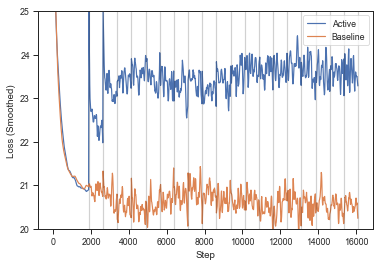

In [108]:
sns.set_style("ticks")
fig, ax = plt.subplots()
ax.plot(active_train_loss_g['step'], active_train_loss_g['smoothed_loss'], label='Active')
ax.plot(baseline_train_loss_g['step'], baseline_train_loss_g['smoothed_loss'], label='Baseline')
for step in acq_steps:
    ax.axvline(step, alpha=0.2, color='k')
ax.set_xlabel('Step')
ax.set_ylabel('Loss (Smoothed)')
ax.set_ylim([20, 25])
ax.legend()
ax.grid(False)
ax.xaxis.grid(False)
ax.xaxis.set_major_formatter(plt.ScalarFormatter())

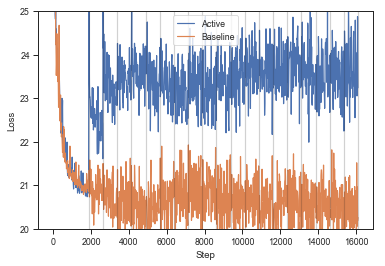

In [109]:
fig, ax = plt.subplots()
ax.plot(active_train_loss_g['step'], active_train_loss_g['loss'], label='Active')
ax.plot(baseline_train_loss_g['step'], baseline_train_loss_g['loss'], label='Baseline')
ax.set_xlabel('Step')
ax.set_ylabel('Loss')
ax.set_ylim([20, 25])
for step in acq_steps:
    ax.axvline(step, alpha=0.2, color='k')
ax.legend()

### Visualise Eval Loss

In [64]:
eval_loss_frac = 0.015
active_a_eval_df = load_tensorboard_metric(results_dir, active_a_str, 23, 'loss', eval_metric=True, frac=eval_loss_frac)
# active_b_eval_df = load_tensorboard_metric(results_dir, active_b_str, 23, 'loss', eval_metric=True, frac=eval_loss_frac)
baseline_a_eval_df = load_tensorboard_metric(results_dir, baseline_a_str, 20, 'loss', eval_metric=True, frac=eval_loss_frac)
# baseline_b_eval_df = load_tensorboard_metric(results_dir, baseline_b_str, 23, 'loss', eval_metric=True, frac=eval_loss_frac)

In [67]:
active_a_eval_df['step'].max(), baseline_a_eval_df['step'].max()

(18795, 16815)

In [68]:
# active_b_eval_df['step'].max(), baseline_b_eval_df['step'].max()

In [69]:
# eval_dfs = [active_a_eval_df, active_b_eval_df, baseline_a_eval_df, baseline_b_eval_df]
eval_dfs = [active_a_eval_df, baseline_a_eval_df]

eval_loss_df = pd.concat(eval_dfs).sort_values('step').reset_index()
active_eval_loss_g = eval_loss_df[eval_loss_df['acquisition'] == 'active'].groupby('step').agg('mean').reset_index()
baseline_eval_loss_g = eval_loss_df[eval_loss_df['acquisition'] == 'baseline'].groupby('step').agg('mean').reset_index()

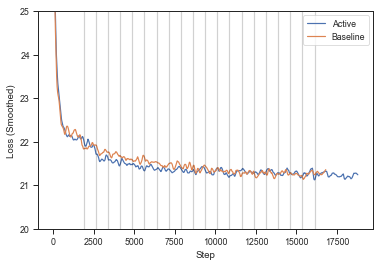

In [73]:
fig, ax = plt.subplots()
ax.plot(active_eval_loss_g['step'], active_eval_loss_g['smoothed_loss'], label='Active')
ax.plot(baseline_eval_loss_g['step'], baseline_eval_loss_g['smoothed_loss'], label='Baseline')
ax.set_xlabel('Step')
ax.set_ylabel('Loss (Smoothed)')
ax.set_ylim([20, 25])
for step in acq_steps:
    ax.axvline(step, alpha=0.2, color='k')
ax.legend()

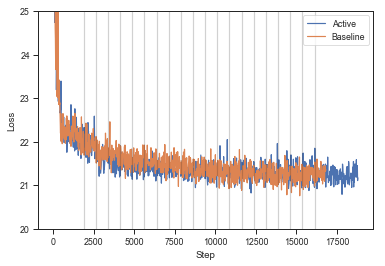

In [76]:
fig, ax = plt.subplots()
ax.plot(active_eval_loss_g['step'], active_eval_loss_g['loss'], label='Active')
ax.plot(baseline_eval_loss_g['step'], baseline_eval_loss_g['loss'], label='Baseline')
ax.set_xlabel('Step')
ax.set_ylabel('Loss')
ax.set_ylim([20, 25])
for step in acq_steps:
    ax.axvline(step, alpha=0.2, color='k')
ax.legend()

In [78]:
rmse_frac = 0.008
active_a_rmse_df = load_tensorboard_metric(results_dir, active_a_str, 23, 'rmse', eval_metric=True, frac=rmse_frac)
# active_b_rmse_df = load_tensorboard_metric(results_dir, active_b_str, 23, 'rmse', eval_metric=True, frac=rmse_frac)
baseline_a_rmse_df = load_tensorboard_metric(results_dir, baseline_a_str, 20, 'rmse', eval_metric=True, frac=rmse_frac)
# baseline_b_rmse_df = load_tensorboard_metric(results_dir, baseline_b_str, 23, 'rmse', eval_metric=True, frac=rmse_frac)

In [81]:
# eval_rmse_dfs = [active_a_rmse_df, active_b_rmse_df, baseline_a_rmse_df, baseline_b_rmse_df]
eval_rmse_dfs = [active_a_rmse_df, baseline_a_rmse_df]

eval_rmse_df = pd.concat(eval_rmse_dfs).sort_values('step').reset_index()
active_rmse_g = eval_rmse_df[eval_rmse_df['acquisition'] == 'active'].groupby('step').agg('mean').reset_index()
baseline_rmse_g = eval_rmse_df[eval_rmse_df['acquisition'] == 'baseline'].groupby('step').agg('mean').reset_index()

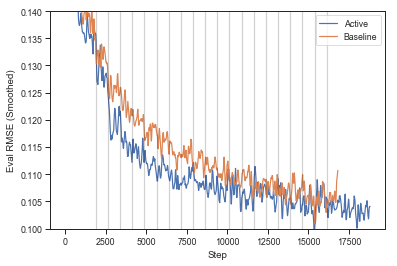

In [91]:
fig, ax = plt.subplots()
ax.plot(active_rmse_g['step'], active_rmse_g['smoothed_rmse'], label='Active')
ax.plot(baseline_rmse_g['step'], baseline_rmse_g['smoothed_rmse'], label='Baseline')
ax.set_ylim([.1, .14])
ax.set_xlabel('Step')
ax.set_ylabel('Eval RMSE (Smoothed)')
for step in acq_steps:
    ax.axvline(step, alpha=0.2, color='k')
ax.legend()

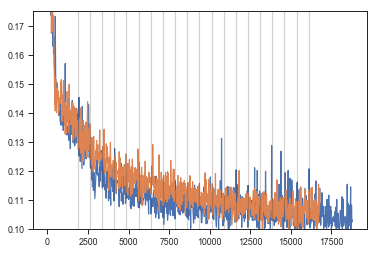

In [85]:
fig, ax = plt.subplots()
ax.plot(active_rmse_g['step'], active_rmse_g['rmse'], label='Active')
ax.plot(baseline_rmse_g['step'], baseline_rmse_g['rmse'], label='Baseline')
# ax.set_ylim([.14, .22])
ax.set_ylim([.1, .175])
for step in acq_steps:
    ax.axvline(step, alpha=0.2, color='k')

### All Together


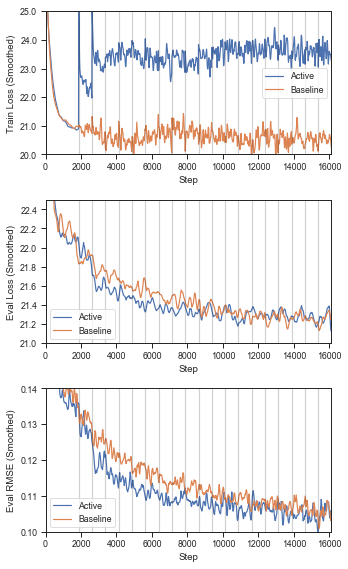

In [114]:
sns.set_style("ticks")

fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, figsize=(5, 8))

# train loss
ax0.plot(active_train_loss_g['step'], active_train_loss_g['smoothed_loss'], label='Active')
ax0.plot(baseline_train_loss_g['step'], baseline_train_loss_g['smoothed_loss'], label='Baseline')
for step in acq_steps:
    ax0.axvline(step, alpha=0.2, color='k')
ax0.set_xlabel('Step')
ax0.set_ylabel('Train Loss (Smoothed)')
ax0.set_ylim([20, 25])
# for some reason, this axis likes being integers. Force to be float, for consistency.
ax0.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: '{:.1f}'.format(x)))
ax0.legend()


# eval loss
ax1.plot(active_eval_loss_g['step'], active_eval_loss_g['smoothed_loss'], label='Active')
ax1.plot(baseline_eval_loss_g['step'], baseline_eval_loss_g['smoothed_loss'], label='Baseline')
ax1.set_xlabel('Step')
ax1.set_ylabel('Eval Loss (Smoothed)')
ax1.set_ylim([21, 22.5])
for step in acq_steps:
    ax1.axvline(step, alpha=0.2, color='k')
ax1.legend()

# rmse
ax2.plot(active_rmse_g['step'], active_rmse_g['smoothed_rmse'], label='Active')
ax2.plot(baseline_rmse_g['step'], baseline_rmse_g['smoothed_rmse'], label='Baseline')
ax2.set_ylim([.1, .14])
ax2.set_xlabel('Step')
ax2.set_ylabel('Eval RMSE (Smoothed)')
for step in acq_steps:
    ax2.axvline(step, alpha=0.2, color='k')
ax2.legend()

# ax0.xaxis.set_major_formatter(plt.NullFormatter())
# ax1.xaxis.set_major_formatter(plt.NullFormatter())
xmax = 16111
# xmax = 18361
ax0.set_xlim([0, xmax])
ax1.set_xlim([0, xmax])
ax2.set_xlim([0, xmax])

# ax0.set_title("GZ2 'Bar' Active Learning Performance")
fig.tight_layout()
fig.savefig(os.path.join(save_dir, 'gz2_active_sim_latest.png'))

In [113]:
max(active_train_loss_g['step']), max(active_eval_loss_g['step']), max(active_rmse_g['step'])

(16111, 18795, 18795)